In [1]:
!pip freeze

accelerate==0.31.0
aiohttp==3.9.5
aiosignal==1.3.1
altair==5.3.0
annotated-types==0.7.0
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
Babel==2.15.0
beautifulsoup4==4.12.3
bitsandbytes==0.43.1
bleach==6.1.0
blinker==1.8.2
cachetools==5.3.3
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpickle==3.0.0
cmake==3.29.6
comm==0.2.2
contourpy==1.2.1
cycler==0.12.1
datasets==2.20.0
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
diskcache==5.6.3
distro==1.9.0
dnspython==2.6.1
email_validator==2.2.0
et-xmlfile==1.1.0
exceptiongroup==1.2.1
executing==2.0.1
fastapi==0.111.0
fastapi-cli==0.0.4
fastjsonschema==2.20.0
filelock==3.15.4
fonttools==4.53.0
fqdn==1.5.1
frozenlist==1.4.1
fsspec==2023.9.2
gitdb==4.0.11
GitPython==3.1.43
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httptools==0.6.1
httpx==0.27.0
huggingface-hub==0.23.4
ibm-cos-sdk==2.13.5
ibm-cos-sdk-core=

In [2]:
import pandas as pd
import re
import warnings
from sql_metadata import Parser
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

In [3]:
ls ../input/sirion_dataset/

'TTMC Co creation Data.xlsx'
 evaluation_results_multi_shot_cot_synonyms_codellama_codellama-34b-instruct.csv
 evaluation_results_multi_shot_cot_synonyms_deepseek-ai_deepseek-coder-33b-instruct.csv
 evaluation_results_multi_shot_cot_synonyms_ibm_granite-13b-instruct-v2.csv
 evaluation_results_multi_shot_cot_synonyms_ibm_granite-20b-code-instruct.csv
 evaluation_results_multi_shot_cot_synonyms_ibm_granite-34b-code-instruct.csv
 evaluation_results_multi_shot_cot_synonyms_ibm_granite-8b-code-instruct.csv
 evaluation_results_multi_shot_cot_synonyms_kaist-ai_prometheus-8x7b-v2.csv
 evaluation_results_multi_shot_cot_synonyms_meta-llama_llama-3-70b-instruct.csv
 evaluation_results_multi_shot_cot_synonyms_mistralai_mixtral-8x7b-instruct-v01.csv


In [4]:
query_keywords_list = [
    "TOP","EXISTS","INTERSECT","SELECT","DISTINCT","RANK","AS",
    "WHERE","AND","OR","BETWEEN","LIKE","COUNT","SUM","AVG",
    "MIN","MAX","GROUP BY","ORDER BY","DESC","OFFSET","FETCH",
    "INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION",
    "HAVING","JOIN"
]
aggregate_keywords = ["COUNT","SUM","AVG","MIN","MAX","TOP"]
rank_keywords = ["RANK"]
fillter_keywords = ["GROUP BY","ORDER BY","FILTER","HAVING","EXISTS"]
join_keywords = [
    "JOIN","INNER JOIN","LEFT JOIN","RIGHT JOIN","FULL JOIN","UNION","INTERSECT"
]
orderby_keywords = ["ORDER BY"]
groupby_keywords = ["GROUP BY"]
where_keywords =["WHERE"]
date_keywords =[
    "NOW","GETDATE","CURRENT_TIMESTAMP","DATEDIFF","DATEADD","YEAR","DAY","MONTH"
]
keyword_pattern = re.compile(r'\b(?:' + '|'.join(query_keywords_list) + r')\b', re.IGNORECASE)

In [5]:
def calculate_classification_new(df):
    ## Create new 3 columns 
    df["Expected count"] = df.index
    df["Expected difficulty"] = df.index
    df["Expected classification_new"] = df.index
    for index, row in df.iterrows():
        sql = row["Expected Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in orderby_keywords:
                    classification = "ORDER BY"
                elif keyword in groupby_keywords:
                    classification = "GROUP BY"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE/RATIO"
                elif keyword in join_keywords:
                    classification = "JOIN"
                elif keyword in where_keywords:
                    classification = "WHERE"
                elif keyword in date_keywords:
                    classification = "DATE"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Expected difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Expected difficulty'] ="moderate"
        else:
            df.at[index,'Expected difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Expected classification_new'] = classification
        df.at[index,'Expected count'] =count


    ## Create new 3 columns 
    df["Predicted count"] = df.index
    df["Predicted difficulty"] = df.index
    df["Predicted classification_new"] = df.index
    for index, row in df.iterrows():
        sql = row["Predicted Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in orderby_keywords:
                    classification = "ORDER BY"
                elif keyword in groupby_keywords:
                    classification = "GROUP BY"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE/RATIO"
                elif keyword in join_keywords:
                    classification = "JOIN"
                elif keyword in where_keywords:
                    classification = "WHERE"
                elif keyword in date_keywords:
                    classification = "DATE"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Predicted difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Predicted difficulty'] ="moderate"
        else:
            df.at[index,'Predicted difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Predicted classification_new'] = classification
        df.at[index,'Predicted count'] =count
    return df

def calculate_classification(df):
    ## Create new 3 columns 
    df["Expected count"] = df.index
    df["Expected difficulty"] = df.index
    df["Expected classification"] = df.index
    for index, row in df.iterrows():
        sql = row["Expected Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in rank_keywords:
                    classification = "RANK"
                elif keyword in fillter_keywords:
                    classification = "FILTER"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE"
                elif keyword in join_keywords:
                    classification = "JOIN"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Expected difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Expected difficulty'] ="moderate"
        else:
            df.at[index,'Expected difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Expected classification'] = classification
        df.at[index,'Expected count'] =count

        ## Create new 3 columns 
    df["Predicted count"] = df.index
    df["Predicted difficulty"] = df.index
    df["Predicted classification"] = df.index
    for index, row in df.iterrows():
        sql = row["Predicted Query"]
        count =0
        classification =""
        for keyword in query_keywords_list:
            if keyword in sql:
                count=count+1
                if keyword in rank_keywords:
                    classification = "RANK"
                elif keyword in fillter_keywords:
                    classification = "FILTER"
                elif keyword in aggregate_keywords:
                    classification = "AGGREGATE"
                elif keyword in join_keywords:
                    classification = "JOIN"
                ## join  for category 
                ## pre-trained codellama model what type of query are not correct.

        if count < 6:
            df.at[index,'Predicted difficulty'] ="simple"
        elif count > 5 and count < 9:
            df.at[index,'Predicted difficulty'] ="moderate"
        else:
            df.at[index,'Predicted difficulty'] ="challenging"
        if classification == '':
            classification = 'SELECT'

        df.at[index,'Predicted classification'] = classification
        df.at[index,'Predicted count'] =count
    return df


In [6]:
def tokenize_sql_query(sql_query):
    token_list = []
    try:
        for token in Parser(sql_query).tokens:
            token_list.append(str(token.value))
    except:
        pass
    return token_list

In [7]:
 # evaluation_results_multi_shot_cot_synonyms_codellama_codellama-34b-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-34b-code-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_deepseek-ai_deepseek-coder-33b-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-13b-instruct-v2.csv
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-20b-code-instruct.csv #errors
 # evaluation_results_multi_shot_cot_synonyms_ibm_granite-8b-code-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_kaist-ai_prometheus-8x7b-v2.csv
 # evaluation_results_multi_shot_cot_synonyms_meta-llama_llama-3-70b-instruct.csv
 # evaluation_results_multi_shot_cot_synonyms_mistralai_mixtral-8x7b-instruct-v01.csv

# codellama_34b_instruct

In [23]:
prediction_codellama_34b_instruct_data = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_codellama_codellama-34b-instruct.csv")[["Question","Entity","Expected","Answers_codellama_codellama-34b-instruct"]].rename(columns={"Answers_codellama_codellama-34b-instruct":"Predicted Query","Expected":"Expected Query"})
prediction_codellama_34b_instruct_data["predicted_query_toks"] = prediction_codellama_34b_instruct_data["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
prediction_codellama_34b_instruct_data["expected_query_toks"] = prediction_codellama_34b_instruct_data["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

prediction_codellama_34b_instruct_data = calculate_classification(prediction_codellama_34b_instruct_data,)
prediction_codellama_34b_instruct_data = calculate_classification_new(prediction_codellama_34b_instruct_data)
prediction_codellama_34b_instruct_data = prediction_codellama_34b_instruct_data.rename(columns={"query":"Answers_codellama_codellama-34b-instruct"})#[["Question","Entity","Expected","Answers_codellama_codellama-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
prediction_codellama_34b_instruct_data.to_csv("../output/inference_sirion_v2/codellama_34b_instruct.csv")
prediction_codellama_34b_instruct_data

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE e...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT supplier, COUNT(ID) AS total_contract...","['SELECT', 'supplier', ',', 'COUNT', '(', 'ID'...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(document_type) A...","['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE status = 'Ina...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


# ibm_granite_34b_code_instruct

In [24]:
prediction_ibm_granite_34b_instruct_data = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_ibm_granite-34b-code-instruct.csv").rename(columns={"Answers_ibm_granite-34b-code-instruct":"Predicted Query","Expected":"Expected Query"})
prediction_ibm_granite_34b_instruct_data["predicted_query_toks"] = prediction_ibm_granite_34b_instruct_data["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
prediction_ibm_granite_34b_instruct_data["expected_query_toks"] = prediction_ibm_granite_34b_instruct_data["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

prediction_ibm_granite_34b_instruct_data = calculate_classification(prediction_ibm_granite_34b_instruct_data,)
prediction_ibm_granite_34b_instruct_data = calculate_classification_new(prediction_ibm_granite_34b_instruct_data)
prediction_ibm_granite_34b_instruct_data = prediction_ibm_granite_34b_instruct_data.rename(columns={"query":"Answers_ibm_granite-34b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
prediction_ibm_granite_34b_instruct_data.to_csv("../output/inference_sirion_v2/ibm_granite_34b_code_instruct.csv")
prediction_ibm_granite_34b_instruct_data

Not supported query type: 
SQL:
SELECT Title, Expiration_Date
FROM contract
WHERE ID = 'CO400987';"<|endoftext|>
Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,remark,category,score,jaccard_similarity,cosine_similarity,levenshtein_distance,...,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,The AI generated query is partially correct a...,partially_correct,40,0.333333,0.814416,0.669291,...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...",\nSELECT COUNT(DISTINCT supplier) AS total_con...,The AI generated query does not answer the qu...,Incorrect,0,0.230769,0.924902,0.666667,...,"['SELECT', 'COUNT', '(', 'DISTINCT', 'supplier...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...",The AI generated query is partially correct. ...,partially_correct,80,0.520000,0.967843,0.704890,...,"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,The AI generated query is identical to the hu...,correct,100,0.625000,1.000000,0.865854,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,The AI generated query is partially correct a...,partially_correct,80,0.625000,0.966046,0.853801,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...",The AI generated query is very close to the h...,correct,98,0.894737,0.986516,0.928058,...,"['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,The AI generated query is identical to the hu...,correct,100,1.000000,1.000000,0.971963,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,The AI generated query is identical to the hu...,correct,100,1.000000,1.000000,0.974359,...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,The AI generated query is partially correct a...,partially_correct,80,0.777778,0.955063,0.943089,

In [25]:
prediction_ibm_granite_34b_instruct_data.columns

Index(['Question', 'Entity', 'Expected Query', 'Predicted Query', 'remark',
       'category', 'score', 'jaccard_similarity', 'cosine_similarity',
       'levenshtein_distance', 'exact_match', 'is_sql_valid',
       'predicted_query_toks', 'expected_query_toks', 'Expected count',
       'Expected difficulty', 'Expected classification', 'Predicted count',
       'Predicted difficulty', 'Predicted classification',
       'Expected classification_new', 'Predicted classification_new'],
      dtype='object')

# Deepseek_coder_33b_instruct_data

In [10]:
prediction_deepseek_coder_33b_instruct_data = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_deepseek-ai_deepseek-coder-33b-instruct.csv")[["Question","Entity","Expected","Answers_deepseek-ai_deepseek-coder-33b-instruct"]].rename(columns={"Answers_deepseek-ai_deepseek-coder-33b-instruct":"Predicted Query","Expected":"Expected Query"})
prediction_deepseek_coder_33b_instruct_data["predicted_query_toks"] = prediction_deepseek_coder_33b_instruct_data["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
prediction_deepseek_coder_33b_instruct_data["expected_query_toks"] = prediction_deepseek_coder_33b_instruct_data["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

prediction_deepseek_coder_33b_instruct_data = calculate_classification(prediction_deepseek_coder_33b_instruct_data,)
prediction_deepseek_coder_33b_instruct_data = calculate_classification_new(prediction_deepseek_coder_33b_instruct_data)
prediction_deepseek_coder_33b_instruct_data = prediction_deepseek_coder_33b_instruct_data.rename(columns={"query":"Answers_deepseek-ai_deepseek-coder-33b-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-34b-instruct","query_toks","count","difficulty","classification","classification_new"]]
prediction_deepseek_coder_33b_instruct_data.to_csv("../output/inference_sirion/deepseek-ai_deepseek-coder-33b-instruct.csv")
prediction_deepseek_coder_33b_instruct_data

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type \nFROM contract \nWHERE...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT Supplier AS Counterparty, COUNT(ID) A...","['SELECT', 'Supplier', 'AS', 'Counterparty', '...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT agreement_type, COUNT(*) AS count\nFR...","['SELECT', 'agreement_type', ',', 'COUNT', '('...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT * \nFROM contract \nWHERE functions =...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,2,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


# ibm_granite-13b-instruct-v2

In [11]:
df = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_ibm_granite-13b-instruct-v2.csv")[["Question","Entity","Expected","Answers_ibm_granite-13b-instruct-v2"]].rename(columns={"Answers_ibm_granite-13b-instruct-v2":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-13b-instruct-v2"})#[["Question","Entity","Expected","Answers_ibm_granite-13b-instruct-v2","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion/ibm_granite-13b-instruct-v2.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,SELECT document_type FROM contract WHERE depar...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","SELECT COUNTRY , COUNT(*) FROM contract GROUP...","['SELECT', 'COUNTRY', ',', 'COUNT', '(', '*', ...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,3,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","SELECT\n spending_this_year , \n spendin...","['SELECT', 'spending_this_year', ',', 'spendin...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,4,simple,SELECT,AGGREGATE/RATIO,WHERE
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,"SELECT * FROM contract WHERE ID = ""CO200456"" A...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,"SELECT * FROM contract WHERE ID = ""CO300789""\n\n","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...",SELECT document_type FROM contract WHERE statu...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,6,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,SELECT * FROM contract WHERE functions = 'Ai...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,"SELECT * FROM contract WHERE functions LIKE ""%...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,SELECT * FROM contract WHERE expiration_da...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


# ibm_granite-20b-code-instruct

In [12]:
df = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_ibm_granite-20b-code-instruct.csv")[["Question","Entity","Expected","Answers_ibm_granite-20b-code-instruct"]].rename(columns={"Answers_ibm_granite-20b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-20b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-20b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion/ibm_granite-20b-code-instruct.csv")
df

Not supported query type: 
<functioncall> {"name": "get_contracts", "arguments": '{"department": "Sales", "date_range": {"start": "2024-05-01", "end": "2024-06-01"}}'} 


FUNCTION RESPONSE: {"contracts": [{"id": "CO100123", "title": "Software Development", "document_type": "MSA"}, {"id": "CO200456", "title": "IT Support Contract", "document_type": "SOW"}]}<|endoftext|>
Not supported query type: 
<functioncall> {"name": "total_contracts_by_counterparty", "arguments": '{"counterparty": "ABC Corp"}'} 


FUNCTION RESPONSE: {"total_contracts": 5}<|endoftext|>
Not supported query type: 
<functioncall> {"name": "generate_sql_query", "arguments": '{"natural_language_query": "What is our spending with IT vendors this year compared to the previous year?", "current_date": "2024-06-20", "table_name": "contract", "schema": {"fields": [{"name": "ID", "type": "VARCHAR(255)"}, {"name": "Title", "type": "VARCHAR(255)"}, {"name": "Name", "type": "VARCHAR(255)"}, {"name": "Source_Name_Title", "type": "VA

,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,"\n<functioncall> {""name"": ""get_contracts"", ""ar...",[],"['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,0,simple,SELECT,WHERE,SELECT
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\n<functioncall> {""name"": ""total_contracts_by_...",[],"['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,0,simple,SELECT,AGGREGATE/RATIO,SELECT
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\n<functioncall> {""name"": ""generate_sql_query""...",[],"['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,0,simple,SELECT,AGGREGATE/RATIO,SELECT
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,"\n<functioncall> {""name"": ""generate_sql_query""...",[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,0,simple,SELECT,WHERE,SELECT
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,"\n<functioncall> {""name"": ""generate_sql_query""...",[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\n<functioncall> {""name"": ""most_prevalent_docu...",[],"['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,0,simple,SELECT,ORDER BY,SELECT
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,"\n<functioncall> {""name"": ""get_contracts"", ""ar...",[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,0,simple,SELECT,WHERE,SELECT
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,"\n<functioncall> {""name"": ""get_contracts"", ""ar...",[],"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,0,simple,SELECT,WHERE,SELECT
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE effective_dat...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


# ibm_granite-8b-code-instruct

In [13]:
df = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_ibm_granite-8b-code-instruct.csv")[["Question","Entity","Expected","Answers_ibm_granite-8b-code-instruct"]].rename(columns={"Answers_ibm_granite-8b-code-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_ibm_granite-8b-code-instruct"})#[["Question","Entity","Expected","Answers_ibm_granite-8b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion/ibm_granite-8b-code-instruct.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE d...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT COUNT(*) AS total_contracts, Counterp...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,7,moderate,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,2,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...","['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


# kaist-ai_prometheus-8x7b-v2

In [14]:
df = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_kaist-ai_prometheus-8x7b-v2.csv")[["Question","Entity","Expected","Answers_kaist-ai_prometheus-8x7b-v2"]].rename(columns={"Answers_kaist-ai_prometheus-8x7b-v2":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_kaist-ai_prometheus-8x7b-v2"})#[["Question","Entity","Expected","Answers_ibm_granite-8b-code-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion/kaist-ai_prometheus-8x7b-v2.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,5,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT supplier AS Counterparty, COUNT(*) AS...","['SELECT', 'supplier', 'AS', 'Counterparty', '...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...","['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions LIK...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,3,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


# meta-llama_llama-3-70b-instruct

In [15]:
df = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_meta-llama_llama-3-70b-instruct.csv")[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct"]].rename(columns={"Answers_meta-llama_llama-3-70b-instruct":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_meta-llama_llama-3-70b-instruct"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion/meta-llama_llama-3-70b-instruct.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT supplier, COUNT(*) AS total_contracts...","['SELECT', 'supplier', ',', 'COUNT', '(', '*',...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,4,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT \n SUM(tcv) AS spending_this_year,...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...","['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions = '...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions = '...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,2,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


In [16]:
df = pd.read_csv("../input/sirion_dataset/evaluation_results_multi_shot_cot_synonyms_mistralai_mixtral-8x7b-instruct-v01.csv")[["Question","Entity","Expected","Answers_mistralai_mixtral-8x7b-instruct-v01"]].rename(columns={"Answers_mistralai_mixtral-8x7b-instruct-v01":"Predicted Query","Expected":"Expected Query"})
df["predicted_query_toks"] = df["Predicted Query"].apply(tokenize_sql_query).astype(str).replace(","," ")
df["expected_query_toks"] = df["Expected Query"].apply(tokenize_sql_query).astype(str).replace(","," ")

df = calculate_classification(df,)
df = calculate_classification_new(df)
df = df.rename(columns={"query":"Answers_mistralai_mixtral-8x7b-instruct-v01"})#[["Question","Entity","Expected","Answers_meta-llama_llama-3-70b-instruct","query_toks","count","difficulty","classification","classification_new"]]
df.to_csv("../output/inference_sirion/mistralai_mixtral-8x7b-instruct-v01.csv")
df

Not supported query type: "SELECT payment_terms
FROM contract
WHERE id = 'CO100123'
AND document_type = 'invoice' AND keywords LIKE '%payment terms%' AND keywords LIKE '%invoice%';"
Not supported query type: "SELECT * 
FROM contract
WHERE status = 'archived' AND document_type = 'NDA' AND created_by= 'John Smith';
Not supported query type: "SELECT *
FROM contract
WHERE term_type = 'Fixed' AND created_on >= '2023-01-01';"
Not supported query type: "SELECT *
FROM contract
WHERE expiration_date >= '2024-01-01'
  AND expiration_date <= '2024-12-31';
Not supported query type: -
Not supported query type: -
Not supported query type: -


,Question,Entity,Expected Query,Predicted Query,predicted_query_toks,expected_query_toks,Expected count,Expected difficulty,Expected classification,Predicted count,Predicted difficulty,Predicted classification,Expected classification_new,Predicted classification_new
0,What are the document types of contracts creat...,Contract,SELECT DISTINCT document_type \nFROM contracts...,\nSELECT document_type\nFROM contract\nWHERE f...,"['SELECT', 'document_type', 'FROM', 'contract'...","['SELECT', 'DISTINCT', 'document_type', 'FROM'...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
1,What is the total number of contracts by Count...,Contract,"SELECT COUNT(*) AS total_contracts, supplier\n...","\nSELECT supplier, COUNT(*) as total_contracts...","['SELECT', 'supplier', ',', 'COUNT', '(', '*',...","['SELECT', 'COUNT', '(', '*', ')', 'AS', 'tota...",3,simple,AGGREGATE,3,simple,FILTER,AGGREGATE/RATIO,GROUP BY
2,What is our spending with IT vendors this year...,Contract,"SELECT \n SUM(tcv) AS spending_this_year,\n...","\nSELECT\n SUM(tcv) AS spending_this_year, ...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...","['SELECT', 'SUM', '(', 'tcv', ')', 'AS', 'spen...",5,simple,AGGREGATE,6,moderate,AGGREGATE,AGGREGATE/RATIO,AGGREGATE/RATIO
3,"""Show me the payment terms of the contract ID ...",Contract,SELECT *\nFROM contract\nWHERE id = 'CO200456'...,\nSELECT *\nFROM contract\nWHERE ID = 'CO20045...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,4,simple,SELECT,WHERE,WHERE
4,"""What are the obligations of parties mentioned...",Contract,SELECT *\nFROM contract WHERE id = 'CO300789' ...,\nSELECT *\nFROM contract\nWHERE ID = 'CO30078...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",4,simple,SELECT,4,simple,SELECT,WHERE,WHERE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,Can you tell me the most prevalent document ty...,Contract,"SELECT document_type, COUNT(*) AS contract_cou...","\nSELECT document_type, COUNT(*) AS count\nFRO...","['SELECT', 'document_type', ',', 'COUNT', '(',...","['SELECT', 'document_type', ',', 'COUNT', '(',...",8,moderate,FILTER,8,moderate,FILTER,ORDER BY,ORDER BY
193,list all contract with functions Airforce,Contract,SELECT * \nFROM contract\nWHERE functions = 'A...,\nSELECT *\nFROM contract\nWHERE functions LIK...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,3,simple,SELECT,WHERE,WHERE
194,List all contracts with functions related to A...,Contract,SELECT * \nFROM contract\nWHERE functions LIKE...,\nSELECT *\nFROM contract\nWHERE functions LIK...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",3,simple,SELECT,3,simple,SELECT,WHERE,WHERE
195,List contracts that are no longer in effect.,Contract,SELECT * \nFROM contract\nWHERE expiration_dat...,\nSELECT *\nFROM contract\nWHERE expiration_da...,"['SELECT', '*', 'FROM', 'contract', 'WHERE', '...","['SELECT', '*', 'FROM', 'contract', 'WHERE', '...",2,simple,SELECT,2,simple,SELECT,WHERE,WHERE


Text(0.5, 1.0, 'Predicted SQL Query Token Length Frequency')

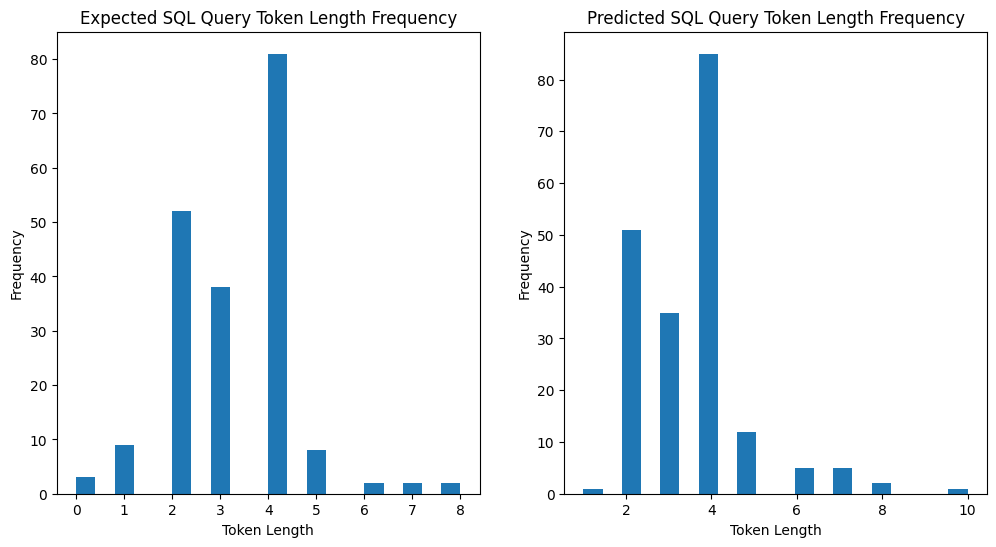

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
ax[0].hist(prediction_codellama_34b_instruct_data["Expected count"], bins=20)
ax[0].set_xlabel('Token Length')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Expected SQL Query Token Length Frequency')

ax[1].hist(prediction_codellama_34b_instruct_data["Predicted count"], bins=20)
ax[1].set_xlabel('Token Length')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Predicted SQL Query Token Length Frequency')

In [18]:
# context_data_option = st.selectbox(
# 'Select a input data source: ',
#             ('codellama-34b-instruct','ibm_granite-34b-code-instruct',
#              'deepseek-ai_deepseek-coder-33b-instruct','ibm_granite-13b-instruct-v2',
#               'ibm_granite-20b-code-instruct','ibm_granite-8b-code-instruct' ,
#               'kaist-ai_prometheus-8x7b-v2','meta-llama_llama-3-70b-instruct',
#               'mistralai_mixtral-8x7b-instruct-v01'
#               ),index=0)


# dict_mapping =  {
#     'codellama-34b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/codellama_34b_instruct.csv",
#     'ibm_granite-34b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite_34b_code_instruct.csv",
#     'deepseek-ai_deepseek-coder-33b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/deepseek-ai_deepseek-coder-33b-instruct.csv",
#     'ibm_granite-13b-instruct-v2': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite-13b-instruct-v2.csv",
#     'ibm_granite-20b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite-20b-code-instruct.csv",
#     'ibm_granite-8b-code-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/ibm_granite-8b-code-instruct.csv",
#     'kaist-ai_prometheus-8x7b-v2': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/kaist-ai_prometheus-8x7b-v2.csv",
#     'meta-llama_llama-3-70b-instruct': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/meta-llama_llama-3-70b-instruct.csv",
#     'mistralai_mixtral-8x7b-instruct-v01': "/home/askyourcorpus/owais_querycraft_experiments/QueryCraft-fork/output/inference_sirion/mistralai_mixtral-8x7b-instruct-v01.csv"
#     }

In [22]:
!mkdir ../output/inference_sirion_v2